In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import re
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Embedding
from tensorflow.keras.layers import GlobalAveragePooling1D, Conv1D, GlobalMaxPooling1D
from tensorflow.keras.callbacks import EarlyStopping

font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 15}

matplotlib.rc('font', **font)

C:\Users\jacop\anaconda3\envs\tf\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
data = pd.read_csv('labeled_data.csv')
# 0->hate 1->offensive 2->none

tweet = data['tweet'].to_list()

cleaned_tweet = []

stop_words = set(stopwords.words('english'))
stop_words.update({'!',',','.','&','@','?',':','#',';','rt','http','``'})
ps = PorterStemmer()

for i in tweet:

    to_clean = i.lower()
    
    no_number = re.sub(r'\d+','',to_clean)
    word_tokens = word_tokenize(no_number)

    filtered_tweet = [w for w in word_tokens if not w in stop_words]
    stemmed_tweet = [ps.stem(w) for w in filtered_tweet]
    stemmed_tweet = " ".join(stemmed_tweet)
    
    cleaned_tweet.append(stemmed_tweet)
    
data.insert(7, 'cleaned_tweet', cleaned_tweet)
data

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet,cleaned_tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...,mayasolov woman n't complain clean hous amp ma...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,mleew boy dat cold ... tyga dwn bad cuffin dat...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,urkindofbrand dawg sbabylif ever fuck bitch st...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,c_g_anderson viva_bas look like tranni
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,shenikarobert shit hear might true might faker...
...,...,...,...,...,...,...,...,...
24778,25291,3,0,2,1,1,you's a muthaf***in lie &#8220;@LifeAsKing: @2...,'s muthaf * * * lie lifeask _pearl corey_emanu...
24779,25292,3,0,1,2,2,"you've gone and broke the wrong heart baby, an...",'ve gone broke wrong heart babi drove redneck ...
24780,25294,3,0,3,0,1,young buck wanna eat!!.. dat nigguh like I ain...,young buck wan na eat .. dat nigguh like aint ...
24781,25295,6,0,6,0,1,youu got wild bitches tellin you lies,youu got wild bitch tellin lie


24783 elementi totali
7301 elementi contesi totali

Classe 0
1430 elementi di cui 1167 contesi (81.6083916083916%)

Classe 1
19190 elementi di cui 4843 contesi (25.237102657634185%)

Classe 2
4163 elementi di cui 1291 contesi (31.011289935142926%)


Text(0.5, 1.0, 'Final label distribution')

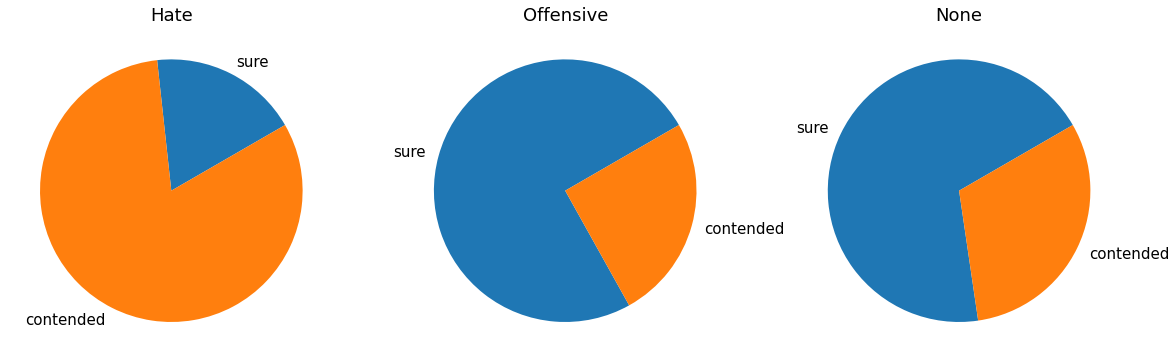

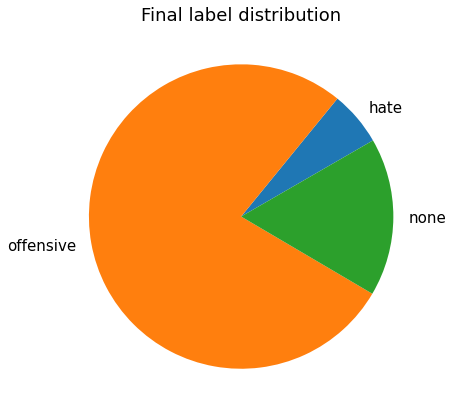

In [3]:
label = data['class'].to_list()

class_conteso = []

for i in range(len(data)):
    
    cl = data['class'][i]
    
    h_voter = data['hate_speech'][i]
    o_voter = data['offensive_language'][i]
    n_voter = data['neither'][i]
    
    vote = np.array([h_voter, o_voter, n_voter])
    
    n_zero = np.count_nonzero(vote==0)

    if n_zero != 2:
    
        class_conteso.append(cl)
        

print(f'{len(label)} elementi totali')        
print(f'{len(class_conteso)} elementi contesi totali')





c_count = []
c_cont_count = []
c_sic_count = []
rel_count = []

fig, ax = plt.subplots(1,3, figsize=(20,7))

for i in range(3):
    
    print()
    print(f'Classe {i}')
    
    c_count.append(np.count_nonzero(np.array(label)==i))
    c_cont_count.append(np.count_nonzero(np.array(class_conteso)==i))
    c_sic_count.append(c_count[i]-c_cont_count[i])
    rel_count.append((c_cont_count[i]/c_count[i])*100)
    
    ax[i].pie([c_sic_count[i],c_cont_count[i]], labels = ['sure','contended'],startangle = 30)
    
    print(f'{c_count[i]} elementi di cui {c_cont_count[i]} contesi ({rel_count[i]}%)')
    
    
    
ax[0].set_title('Hate')
ax[1].set_title('Offensive')
ax[2].set_title('None')    
    
fig= plt.figure(figsize=(20,7))
plt.pie(c_count, labels = ['hate','offensive','none'],startangle = 30)
plt.title('Final label distribution')

Text(0.5, 1.0, 'Overall')

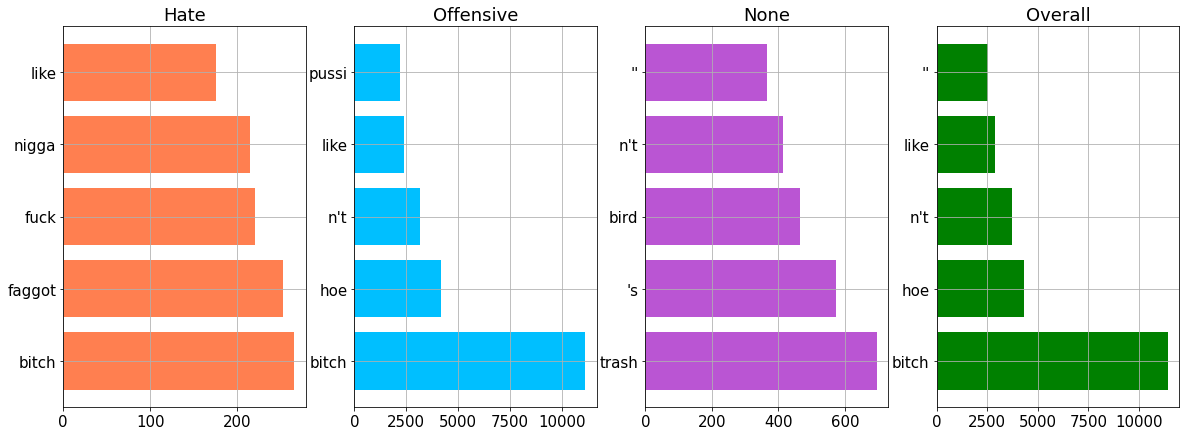

In [4]:
fig, axs = plt.subplots(1,4, figsize = (20,7))
colors = ['coral','deepskyblue','mediumorchid']


most_common = data.cleaned_tweet.str.split(expand=True).stack().value_counts()
most_common = pd.DataFrame(most_common)

for i in range(5):
    d = most_common.index[i]
    axs[3].barh(d, most_common[0][i], color = 'green')
    axs[3].grid()
    

for j in range(3):

    filter = data['class'] == j
    filtered = data.where(filter).dropna().reset_index()

    c = filtered.cleaned_tweet.str.split(expand=True).stack().value_counts()
    c = pd.DataFrame(c)

    for i in range(5):
        d = c.index[i]
        axs[j].barh(d, c[0][i], color = colors[j])
    
    axs[j].grid()


axs[0].set_title('Hate')
axs[1].set_title('Offensive')
axs[2].set_title('None')
axs[3].set_title('Overall')

In [5]:
tweet_list = data['cleaned_tweet'].to_list()

tokenizer = Tokenizer(split = ' ')
tokenizer.fit_on_texts(tweet_list)
X = tokenizer.texts_to_sequences(tweet_list)
Y = label

l = []
for i in range(len(X)):
    l.append(len(X[i]))
    
maxlen = 29
    
X = pad_sequences(X, maxlen=maxlen)

X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.1, random_state=42)

print(f'Train shape: {X_train.shape}')
print(f'Test shape: {X_test.shape}')

X

Train shape: (22304, 29)
Test shape: (2479, 29)


array([[    0,     0,     0, ...,   102,    66,    18],
       [    0,     0,     0, ...,     2,   449,   411],
       [    0,     0,     0, ...,   254,   806,    16],
       ...,
       [    0,     0,     0, ...,   117,   116,   265],
       [    0,     0,     0, ...,     1,  1853,   214],
       [    0,     0,     0, ...,     4,     5, 30375]])

In [6]:
X[0]

array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
       10676,   280,     3,   623,   563,   228,    20,    37,   102,
          66,    18])

In [7]:
batch_size = 640
epochs = 40
filters = 128
kernel_size = 1
hidden_dims = 128
embedding_dim = 30
max_features = 10
n_outputs = 3


vocab_size = len(tokenizer.word_index) + 1

print('Buiding model...')
model = Sequential()

model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=maxlen))
model.add(Conv1D(filters, kernel_size, activation= 'relu', strides=1))
model.add(GlobalMaxPooling1D())
model.add(Dense(hidden_dims))
model.add(Dropout(0.2))
model.add(Activation('relu'))
model.add(Dense(hidden_dims))
#model.add(Dropout(0.2))
#model.add(Activation('relu'))
#model.add(Dense(16))
model.add(Activation('softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

model.summary()

Buiding model...
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 29, 30)            911280    
                                                                 
 conv1d (Conv1D)             (None, 29, 128)           3968      
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 128)               16512     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 activation (Activation)     (None, 128)               0         
                                       

In [8]:
callback = EarlyStopping(monitor='val_loss', min_delta = 0, patience = 5, verbose = 0, mode = 'auto',
                        baseline = None, restore_best_weights = False)

history = model.fit(np.array(X_train), np.array(Y_train), batch_size=batch_size, epochs=epochs,
                   validation_split=0.1,callbacks = [callback])

Epoch 1/40
32/32 [==============================] - 4s 62ms/step - loss: 3.6721 - accuracy: 0.7551 - val_loss: 1.2723 - val_accuracy: 0.7813
Epoch 2/40
32/32 [==============================] - 1s 47ms/step - loss: 0.8419 - accuracy: 0.7742 - val_loss: 0.6089 - val_accuracy: 0.7813
Epoch 3/40
32/32 [==============================] - 2s 49ms/step - loss: 0.5861 - accuracy: 0.7742 - val_loss: 0.5097 - val_accuracy: 0.7813
Epoch 4/40
32/32 [==============================] - 1s 46ms/step - loss: 0.4771 - accuracy: 0.7972 - val_loss: 0.4152 - val_accuracy: 0.8194
Epoch 5/40
32/32 [==============================] - 1s 46ms/step - loss: 0.3649 - accuracy: 0.8908 - val_loss: 0.3374 - val_accuracy: 0.8870
Epoch 6/40
32/32 [==============================] - 2s 50ms/step - loss: 0.2871 - accuracy: 0.9194 - val_loss: 0.3026 - val_accuracy: 0.9000
Epoch 7/40
32/32 [==============================] - 2s 48ms/step - loss: 0.2473 - accuracy: 0.9260 - val_loss: 0.2988 - val_accuracy: 0.9054
Epoch 8/40
32

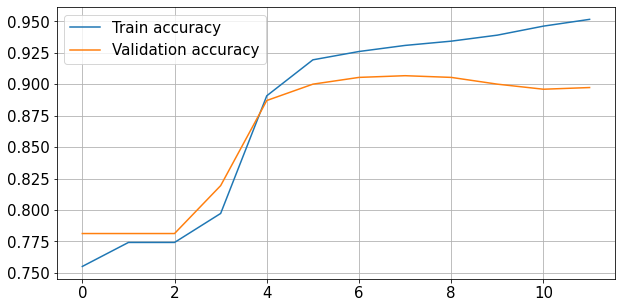

In [9]:
plt.figure(figsize = (10,5))
plt.plot(history.history['accuracy'], label='Train accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.grid()
plt.legend()

In [10]:
print('Metrics on test set:')
model.evaluate(x=np.array(X_test), y=np.array(Y_test))

Metrics on test set:
78/78 [==============================] - 0s 3ms/step - loss: 0.4244 - accuracy: 0.8802


[0.4243551194667816, 0.8801936507225037]

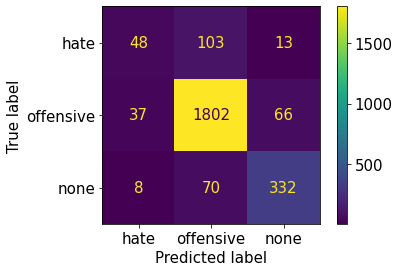

In [11]:
y_pred = model.predict(np.array(X_test)).argmax(-1)
cm = confusion_matrix(np.array(Y_test), np.array(y_pred))
disp = ConfusionMatrixDisplay(cm, display_labels=['hate','offensive','none'])

disp.plot()